# Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from scipy import stats

# Helpers

In [2]:
# Helper block for LR model metrics

scores=pd.DataFrame(columns=['Model','MAE_Train','MSE_Train','RMSE_Train','MAPE_Train','MAE_Test','MSE_Test','RMSE_Test','MAPE_Test','R2'])

def get_metrics(y_train, y_train_pred, y_test, y_test_pred, model_name, scores):
    from sklearn import metrics
    import numpy as np
    
    def mean_absolute_percentage_error(y_true, y_pred):
        # Calculate Mean Absolute Percentage Error (MAPE)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Calculate metrics
    MAE_Train = metrics.mean_absolute_error(y_train, y_train_pred)
    MSE_Train = metrics.mean_squared_error(y_train, y_train_pred)
    RMSE_Train = np.sqrt(MSE_Train)
    MAPE_Train = mean_absolute_percentage_error(y_train, y_train_pred)
    RSE_Train = np.sum((y_train - y_train_pred) ** 2) / np.sum((y_train - np.mean(y_train)) ** 2)
    RAE_Train = np.sum(np.abs(y_train - y_train_pred)) / np.sum(np.abs(y_train - np.mean(y_train)))
    
        
    MAE_Test = metrics.mean_absolute_error(y_test, y_test_pred)
    MSE_Test = metrics.mean_squared_error(y_test, y_test_pred)
    RMSE_Test = np.sqrt(MSE_Test)
    MAPE_Test = mean_absolute_percentage_error(y_test, y_test_pred)
    RSE_Test = np.sum((y_test - y_test_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2)
    RAE_Test = np.sum(np.abs(y_test - y_test_pred)) / np.sum(np.abs(y_test - np.mean(y_test)))
    R2 = metrics.r2_score(y_train, y_train_pred)
    # R2_formatted = np.format_float_scientific(R2, precision=5)  # or use format if you want
            
    # Create a DataFrame with new metrics
    new_metrics = pd.DataFrame({
        'Model'     : [model_name],
        'MAE_Train' : [MAE_Train],
        'MSE_Train' : [MSE_Train],
        'RMSE_Train': [RMSE_Train],
        'MAPE_Train': [MAPE_Train],
        'RAE_Train' : [RAE_Train],
        'RSE_Train' : [RSE_Train],
        'MAE_Test'  : [MAE_Test],
        'MSE_Test'  : [MSE_Test],
        'RMSE_Test' : [RMSE_Test],
        'MAPE_Test' : [MAPE_Test],
        'RAE_Test'  : [RAE_Test],
        'RSE_Test'  : [RSE_Test],
             'R2'   : [R2]
    })
    # Update scores DataFrame
    # scores = new_metrics
    # Append the new metrics to the existing scores DataFrame
    scores = pd.concat([scores if not scores.empty else None, new_metrics], ignore_index=True)
    return scores

In [3]:
# Helper block for residual plots

# Check for Linearity, Homoscedasticity, Independence of residuals

# Residuals vs Fitted plot analyis: The residuals should be randomly scattered around the centerline of 0.
# Linearity: Residuals spread randomly across the range of fitted values without a clear pattern,
#            indicating that the model is likely linear.
# Homoscedasticity: Residuals have a relatively constant spread across the fitted values, with no evident "fanning" pattern.
#                   This suggests that the model does not have severe issues with heteroscedasticity.
# Independence of Errors: Residuals appear to be randomly scattered around the horizontal axis (at 0)
#                         with no discernible pattern or systematic trend, indicating that the residuals may be independent.
#                         No Clustering: There is no visible grouping or correlation between the residuals and fitted values.
#                         If there were patterns like a funnel shape, waves, or clustering, it would suggest a violation of independence.


# Q-Q plot analysis:
# Overprediction: Points in the tails of the Q-Q plot will deviate from the reference line.
# In the left tail, points are above the line, and in the right tail, points are below the line.
# Underprediction: Points in the tails will also deviate from the reference line, but in the opposite manner.
# In the left tail, points are below the line, and in the right tail, points are above the line.

# Homescedasticity/Heteroscedasticity:
# Plot shows "U-shaped" pattern, where residuals start higher on the left, decrease in the middle, and increase again on the right.
# This pattern indicates HETEROSCEDASTICITY, meaning the variance of the residuals is not constant across the range of fitted values.
# FOR HOMOSCEDASTICITY, The residuals are spread evenly across the range of fitted (predicted) values, with no clear pattern
# (i.e., the residuals should not fan out or funnel as you move along the x-axis).

# RESIDUALS VS LEVERAGE:
# Outliers: The point with a very large studentized residual is a likely outlier.
# Leverage: There aren’t any extreme leverage points, suggesting that most data points are not far from the mean of the independent variables.
# Influential points: The point near the Cook’s Distance contour of 1 (possibly 499) is potentially influential
# and may be unduly affecting the model.

def residual_plots(results):
    import matplotlib.pyplot as plt
    import statsmodels.formula.api as smf
    from statsmodels.nonparametric.smoothers_lowess import lowess
    from scipy import stats
    import statsmodels.api as sm


    fig, ax = plt.subplots(2,2,figsize=(14,10))
    ########## Residuals vs fitted  ##########
    residuals = results.resid
    fitted = results.fittedvalues
    smoothed = lowess(residuals,fitted)
    top3 = abs(residuals).sort_values(ascending = False)[:3]

    plt.rcParams.update({'font.size': 10})
    plt.rcParams["figure.figsize"] = (8,7)

    ax[0,0].scatter(fitted, residuals, edgecolors = 'k', facecolors = (0, 0, 1, 0.5))
    ax[0,0].plot(smoothed[:,0],smoothed[:,1],color = 'r')
    ax[0,0].set_ylabel('Residuals')
    ax[0,0].set_xlabel('Fitted Values (Predicted Values)')
    ax[0,0].set_title('Residuals vs. Fitted')
    ax[0,0].plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

    for i in top3.index:
        ax[0,0].annotate(i,xy=(fitted[i],residuals[i]))

    #plt.show()


    ######### Normal qq plot ###########
    sorted_student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
    sorted_student_residuals.index = results.resid.index
    sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
    df = pd.DataFrame(sorted_student_residuals)
    df.columns = ['sorted_student_residuals']
    df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
    rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)
    top3 = rankings[:3]

    #fig, ax = plt.subplots()
    x = df['theoretical_quantiles']
    y = df['sorted_student_residuals']
    ax[0,1].scatter(x,y, edgecolor = 'k',facecolor = (0, 0, 1, 0.5))
    ax[0,1].set_title('Normal Q-Q')
    ax[0,1].set_ylabel('Standardized Residuals')
    ax[0,1].set_xlabel('Theoretical Quantiles')
    ax[0,1].plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
    for val in top3.index:
        ax[0,1].annotate(val,xy=(df['theoretical_quantiles'].loc[val],df['sorted_student_residuals'].loc[val]))
    #plt.show()


    ######### Homoscedasticity ############
    student_residuals = results.get_influence().resid_studentized_internal
    sqrt_student_residuals = pd.Series(np.sqrt(np.abs(student_residuals)))
    sqrt_student_residuals.index = results.resid.index
    smoothed = lowess(sqrt_student_residuals,fitted)
    top3 = abs(sqrt_student_residuals).sort_values(ascending = False)[:3]

    #fig, ax = plt.subplots()
    ax[1,0].scatter(fitted, sqrt_student_residuals, edgecolors = 'k', facecolors = (0, 0, 1, 0.5))
    ax[1,0].plot(smoothed[:,0],smoothed[:,1],color = 'r', label='LOESS Smoothing Line (Trend Line)')
    ax[1,0].set_ylabel('$sqrt{|Studentized Residuals|}$')
    ax[1,0].set_xlabel('Fitted Values (Predicted Values)')
    ax[1,0].set_title('Scale-Location/Spread-Location (Constant Variance of Residuals)')
    ax[1,0].set_ylim(0,max(sqrt_student_residuals)+0.1)
    for i in top3.index:
        ax[1,0].annotate(i,xy=(fitted[i],sqrt_student_residuals[i]))
    #plt.show()


    ######### Cooks distance  ###########
    student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
    student_residuals.index = results.resid.index
    df = pd.DataFrame(student_residuals)
    df.columns = ['student_residuals']
    df['leverage'] = results.get_influence().hat_matrix_diag
    smoothed = lowess(df['student_residuals'],df['leverage'])
    sorted_student_residuals = abs(df['student_residuals']).sort_values(ascending = False)
    top3 = sorted_student_residuals[:3]

    #fig, ax = plt.subplots()
    x = df['leverage']
    y = df['student_residuals']
    xpos = max(x)+max(x)*0.01
    ax[1,1].scatter(x, y, edgecolors = 'k', facecolors = (0, 0, 1, 0.5))
    ax[1,1].plot(smoothed[:,0],smoothed[:,1],color = 'b')
    ax[1,1].set_ylabel('Studentized Residuals')
    ax[1,1].set_xlabel('Leverage')
    ax[1,1].set_title('Residuals vs. Leverage')
    ax[1,1].set_ylim(min(y)-min(y)*0.15,max(y)+max(y)*0.15)
    ax[1,1].set_xlim(-0.01,max(x)+max(x)*0.05)
    plt.tight_layout()
    for val in top3.index:
        ax[1,1].annotate(val,xy=(x.loc[val],y.loc[val]))

    cooksx = np.linspace(min(x), xpos, 50)
    p = len(results.params)
    poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
    poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
    negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
    negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)

    ax[1,1].plot(cooksx,poscooks1y,label = "Cook's Distance", ls = ':', color = 'r')
    ax[1,1].plot(cooksx,poscooks05y, ls = ':', color = 'r')
    ax[1,1].plot(cooksx,negcooks1y, ls = ':', color = 'r')
    ax[1,1].plot(cooksx,negcooks05y, ls = ':', color = 'r')
    ax[1,1].plot([0,0],ax[1,1].get_ylim(), ls=":", alpha = .3, color = 'k')
    ax[1,1].plot(ax[1,1].get_xlim(), [0,0], ls=":", alpha = .3, color = 'k')
    ax[1,1].annotate('1.0', xy = (xpos, poscooks1y[-1]), color = 'r')
    ax[1,1].annotate('0.5', xy = (xpos, poscooks05y[-1]), color = 'r')
    ax[1,1].annotate('1.0', xy = (xpos, negcooks1y[-1]), color = 'r')
    ax[1,1].annotate('0.5', xy = (xpos, negcooks05y[-1]), color = 'r')
    ax[1,1].legend()
    plt.show()

# Read and examine data

In [4]:
# Read the dataset
housing = pd.read_csv("BostonHousing.csv")
housing.head(4)

crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   

        b  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [6]:
housing.describe()

crim          zn       indus        chas         nox          rm  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              age         dis         rad         tax     ptratio           b  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.105710    8.707259  168.537116    2.164946   91.294864   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000  375.377500   
50%     77.500000    3.207450    5.000000  330.000000   19.050000  391.440000   
75%     94.075000    5.188425   24.000000  666.000000   20.200000  396.225000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            lstat        medv  
count  506.000000  506.000000  
mean    12.653063   22.532806  
std      7.141062    9.197104  
min      1.730000    5.000000  
25%      6.950000   17.025000  
50%     11.360000   21.200000  
75%     16.955000   25.000000  
max     37.970000   50.000000

# Data cleanup and transformation

In [7]:
# Dummify (One-Hot Encode)

# RAD: index of accessibility to radial highways (categorical)
housing['rad'] = housing['rad'].astype(int)  # Ensure it's treated as an integer categorical column
housing_tf = pd.get_dummies(housing, columns=['rad'], drop_first=True)  # Drop first to avoid multicollinearity

In [8]:
# Check for non-numeric columns
non_numeric_cols = housing_tf.select_dtypes(exclude=np.number).columns
for col in non_numeric_cols:
  housing_tf[col] = housing_tf[col].astype(int)

In [9]:
housing_tf.head(4)

crim    zn  indus  chas    nox     rm   age     dis  tax  ptratio  ...  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900  296     15.3  ...   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671  242     17.8  ...   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671  242     17.8  ...   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622  222     18.7  ...   

   lstat  medv  rad_2  rad_3  rad_4  rad_5  rad_6  rad_7  rad_8  rad_24  
0   4.98  24.0      0      0      0      0      0      0      0       0  
1   9.14  21.6      1      0      0      0      0      0      0       0  
2   4.03  34.7      1      0      0      0      0      0      0       0  
3   2.94  33.4      0      1      0      0      0      0      0       0  

[4 rows x 21 columns]

In [10]:
housing_tf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   tax      506 non-null    int64  
 9   ptratio  506 non-null    float64
 10  b        506 non-null    float64
 11  lstat    506 non-null    float64
 12  medv     506 non-null    float64
 13  rad_2    506 non-null    int64  
 14  rad_3    506 non-null    int64  
 15  rad_4    506 non-null    int64  
 16  rad_5    506 non-null    int64  
 17  rad_6    506 non-null    int64  
 18  rad_7    506 non-null    int64  
 19  rad_8    506 non-null    int64  
 20  rad_24   506 non-null    int64  
dtypes: float64(11), 

# Full Model

In [11]:
# set the dependent variable and features
X = housing_tf.drop(['medv'], axis=1)
y = pd.Series(housing_tf.medv, name='PRICE')

In [12]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   tax      506 non-null    int64  
 9   ptratio  506 non-null    float64
 10  b        506 non-null    float64
 11  lstat    506 non-null    float64
 12  rad_2    506 non-null    int64  
 13  rad_3    506 non-null    int64  
 14  rad_4    506 non-null    int64  
 15  rad_5    506 non-null    int64  
 16  rad_6    506 non-null    int64  
 17  rad_7    506 non-null    int64  
 18  rad_8    506 non-null    int64  
 19  rad_24   506 non-null    int64  
dtypes: float64(10), int64(10)
memory usage: 79.2 KB


In [13]:
X.describe()

crim          zn       indus        chas         nox          rm  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              age         dis         tax     ptratio           b       lstat  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043  408.237154   18.455534  356.674032   12.653063   
std     28.148861    2.105710  168.537116    2.164946   91.294864    7.141062   
min      2.900000    1.129600  187.000000   12.600000    0.320000    1.730000   
25%     45.025000    2.100175  279.000000   17.400000  375.377500    6.950000   
50%     77.500000    3.207450  330.000000   19.050000  391.440000   11.360000   
75%     94.075000    5.188425  666.000000   20.200000  396.225000   16.955000   
max    100.000000   12.126500  711.000000   22.000000  396.900000   37.970000   

            rad_2       rad_3       rad_4       rad_5       rad_6       rad_7  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     0.047431    0.075099    0.217391    0.227273    0.051383    0.033597   
std      0.212769    0.263812    0.412879    0.419485    0.220997    0.180367   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

            rad_8      rad_24  
count  506.000000  506.000000  
mean     0.047431    0.260870  
std      0.212769    0.439543  
min      0.000000    0.000000  
25%      0.000000    0.000000  
50%      0.000000    0.000000  
75%      0.000000    1.000000  
max      1.000000    1.000000

In [14]:
# add constant to the model
X_const = sm.add_constant(X)
X_const.head(5)

const     crim    zn  indus  chas    nox     rm   age     dis  tax  ...  \
0    1.0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900  296  ...   
1    1.0  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671  242  ...   
2    1.0  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671  242  ...   
3    1.0  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622  222  ...   
4    1.0  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622  222  ...   

        b  lstat  rad_2  rad_3  rad_4  rad_5  rad_6  rad_7  rad_8  rad_24  
0  396.90   4.98      0      0      0      0      0      0      0       0  
1  396.90   9.14      1      0      0      0      0      0      0       0  
2  392.83   4.03      1      0      0      0      0      0      0       0  
3  394.63   2.94      0      1      0      0      0      0      0       0  
4  396.90   5.33      0      1      0      0      0      0      0       0  

[5 rows x 21 columns]

In [15]:
# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_const, y, test_size=0.2, random_state=42)

X_train.info()
print("\n")
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404 entries, 477 to 102
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   const    404 non-null    float64
 1   crim     404 non-null    float64
 2   zn       404 non-null    float64
 3   indus    404 non-null    float64
 4   chas     404 non-null    int64  
 5   nox      404 non-null    float64
 6   rm       404 non-null    float64
 7   age      404 non-null    float64
 8   dis      404 non-null    float64
 9   tax      404 non-null    int64  
 10  ptratio  404 non-null    float64
 11  b        404 non-null    float64
 12  lstat    404 non-null    float64
 13  rad_2    404 non-null    int64  
 14  rad_3    404 non-null    int64  
 15  rad_4    404 non-null    int64  
 16  rad_5    404 non-null    int64  
 17  rad_6    404 non-null    int64  
 18  rad_7    404 non-null    int64  
 19  rad_8    404 non-null    int64  
 20  rad_24   404 non-null    int64  
dtypes: float64(11), int

In [16]:
# build the multiple linear regression full model
model_full = sm.OLS(y_train, X_train).fit()
print("Model Full:\n")
print(model_full.summary())

Model Full:

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     61.59
Date:                Sun, 22 Sep 2024   Prob (F-statistic):          2.26e-106
Time:                        14:30:16   Log-Likelihood:                -1184.4
No. Observations:                 404   AIC:                             2411.
Df Residuals:                     383   BIC:                             2495.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.9224      6.044      4

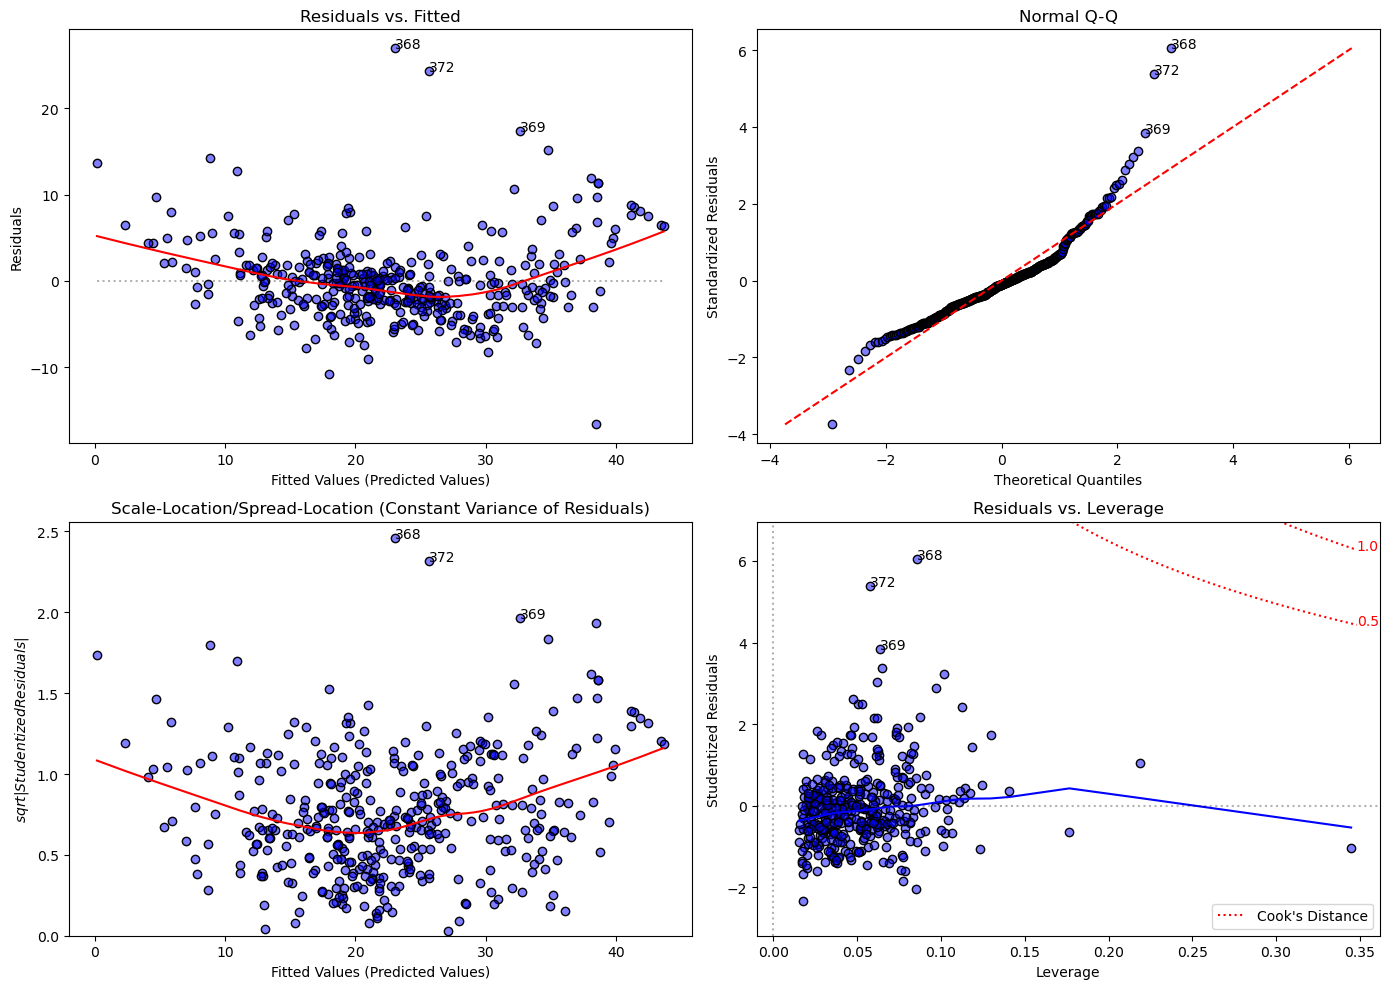

In [17]:
residual_plots(model_full)

In [18]:
scores = get_metrics(y_train, model_full.predict(X_train), y_test, model_full.predict(X_test), "Full Model", scores)

# Model without influental datapoints

There were no influental datapoints with Cook distance > 1 (Check residual vs leverage plot).

# Data Transformation

#### Box-Cox on X

In [19]:
# Data input to box-cox must be +ve
#X_train_box_cox, lambda_bc = stats.boxcox(X_train.iloc[:,4])
#X_test_box_cox, lambda_bc = stats.boxcox(X_test.iloc[:,4])
X_train.info()
print("\n")
X_train.iloc[:,0].head(5)

<class 'pandas.core.frame.DataFrame'>
Index: 404 entries, 477 to 102
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   const    404 non-null    float64
 1   crim     404 non-null    float64
 2   zn       404 non-null    float64
 3   indus    404 non-null    float64
 4   chas     404 non-null    int64  
 5   nox      404 non-null    float64
 6   rm       404 non-null    float64
 7   age      404 non-null    float64
 8   dis      404 non-null    float64
 9   tax      404 non-null    int64  
 10  ptratio  404 non-null    float64
 11  b        404 non-null    float64
 12  lstat    404 non-null    float64
 13  rad_2    404 non-null    int64  
 14  rad_3    404 non-null    int64  
 15  rad_4    404 non-null    int64  
 16  rad_5    404 non-null    int64  
 17  rad_6    404 non-null    int64  
 18  rad_7    404 non-null    int64  
 19  rad_8    404 non-null    int64  
 20  rad_24   404 non-null    int64  
dtypes: float64(11), int

477    1.0
15     1.0
332    1.0
423    1.0
19     1.0
Name: const, dtype: float64

#### Yeo-Johnson with PowerTransformer

It allows transformaing multiple variables at once.

In [20]:
cat_columns = [c for c in X.columns.values if c.startswith("rad")]
X_no_cat = X.drop(columns=cat_columns)
X_no_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   tax      506 non-null    int64  
 9   ptratio  506 non-null    float64
 10  b        506 non-null    float64
 11  lstat    506 non-null    float64
dtypes: float64(10), int64(2)
memory usage: 47.6 KB


In [21]:
from sklearn.preprocessing import PowerTransformer

pt_yeojohnson = PowerTransformer(method='yeo-johnson')
X_transformed_no_cat = pt_yeojohnson.fit_transform(X_no_cat)

print("Lambda values for each variable (Yeo-Johnson):", pt_yeojohnson.lambdas_)

Lambda values for each variable (Yeo-Johnson): [ -0.95389724  -0.90529801   0.37915192 -20.85708924  -3.97371104
   0.33298651   1.36614005  -0.44887192  -0.52917651   4.55770392
   3.77813398   0.15370552]


In [22]:
no_cat_columns = [c for c in X.columns.values if not c.startswith("rad")]
X_transformed = pd.DataFrame(X_transformed_no_cat, columns=no_cat_columns)
X_transformed = pd.concat([X_transformed, X.drop(columns=no_cat_columns)], axis=1)
X_transformed.head(4)

crim        zn     indus      chas       nox        rm       age  \
0 -1.056151  1.605270 -1.523776 -0.272599  0.027165  0.441377 -0.212875   
1 -0.999901 -0.599954 -0.443938 -0.272599 -0.716093  0.225621  0.314385   
2 -0.999953 -0.599954 -0.443938 -0.272599 -0.716093  1.268348 -0.363383   
3 -0.986675 -0.599954 -1.564275 -0.272599 -0.851247  1.019336 -0.891929   

        dis       tax   ptratio         b     lstat  rad_2  rad_3  rad_4  \
0  0.443907 -0.556334 -1.408874  0.632757 -1.257099      0      0      0   
1  0.796950 -1.175887 -0.518692  0.632757 -0.334422      1      0      0   
2  0.796950 -1.175887 -0.518692  0.502065 -1.543453      1      0      0   
3  1.144611 -1.461842 -0.076443  0.559404 -1.934975      0      1      0   

   rad_5  rad_6  rad_7  rad_8  rad_24  
0      0      0      0      0       0  
1      0      0      0      0       0  
2      0      0      0      0       0  
3      0      0      0      0       0

In [23]:
X_transformed_const = sm.add_constant(X_transformed)
X_transformed_const.head(4)

const      crim        zn     indus      chas       nox        rm  \
0    1.0 -1.056151  1.605270 -1.523776 -0.272599  0.027165  0.441377   
1    1.0 -0.999901 -0.599954 -0.443938 -0.272599 -0.716093  0.225621   
2    1.0 -0.999953 -0.599954 -0.443938 -0.272599 -0.716093  1.268348   
3    1.0 -0.986675 -0.599954 -1.564275 -0.272599 -0.851247  1.019336   

        age       dis       tax  ...         b     lstat  rad_2  rad_3  rad_4  \
0 -0.212875  0.443907 -0.556334  ...  0.632757 -1.257099      0      0      0   
1  0.314385  0.796950 -1.175887  ...  0.632757 -0.334422      1      0      0   
2 -0.363383  0.796950 -1.175887  ...  0.502065 -1.543453      1      0      0   
3 -0.891929  1.144611 -1.461842  ...  0.559404 -1.934975      0      1      0   

   rad_5  rad_6  rad_7  rad_8  rad_24  
0      0      0      0      0       0  
1      0      0      0      0       0  
2      0      0      0      0       0  
3      0      0      0      0       0  

[4 rows x 21 columns]

In [24]:
# split the data into train and test sets
X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed = train_test_split(X_transformed_const, y, test_size=0.2, random_state=101)

X_train_transformed.info()
print("\n")
y_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404 entries, 288 to 351
Data columns (total 21 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   const    404 non-null    float64
 1   crim     404 non-null    float64
 2   zn       404 non-null    float64
 3   indus    404 non-null    float64
 4   chas     404 non-null    float64
 5   nox      404 non-null    float64
 6   rm       404 non-null    float64
 7   age      404 non-null    float64
 8   dis      404 non-null    float64
 9   tax      404 non-null    float64
 10  ptratio  404 non-null    float64
 11  b        404 non-null    float64
 12  lstat    404 non-null    float64
 13  rad_2    404 non-null    int64  
 14  rad_3    404 non-null    int64  
 15  rad_4    404 non-null    int64  
 16  rad_5    404 non-null    int64  
 17  rad_6    404 non-null    int64  
 18  rad_7    404 non-null    int64  
 19  rad_8    404 non-null    int64  
 20  rad_24   404 non-null    int64  
dtypes: float64(13), int

In [25]:
# build the multiple linear regression transformed full model
model_transformed_full = sm.OLS(y_train_transformed, X_train_transformed).fit()
print("Model Transformed Full:\n")
print(model_transformed_full.summary())

Model Full:

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     68.71
Date:                Sun, 22 Sep 2024   Prob (F-statistic):          2.67e-113
Time:                        14:30:17   Log-Likelihood:                -1143.5
No. Observations:                 404   AIC:                             2329.
Df Residuals:                     383   BIC:                             2413.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.2181      1.181     16

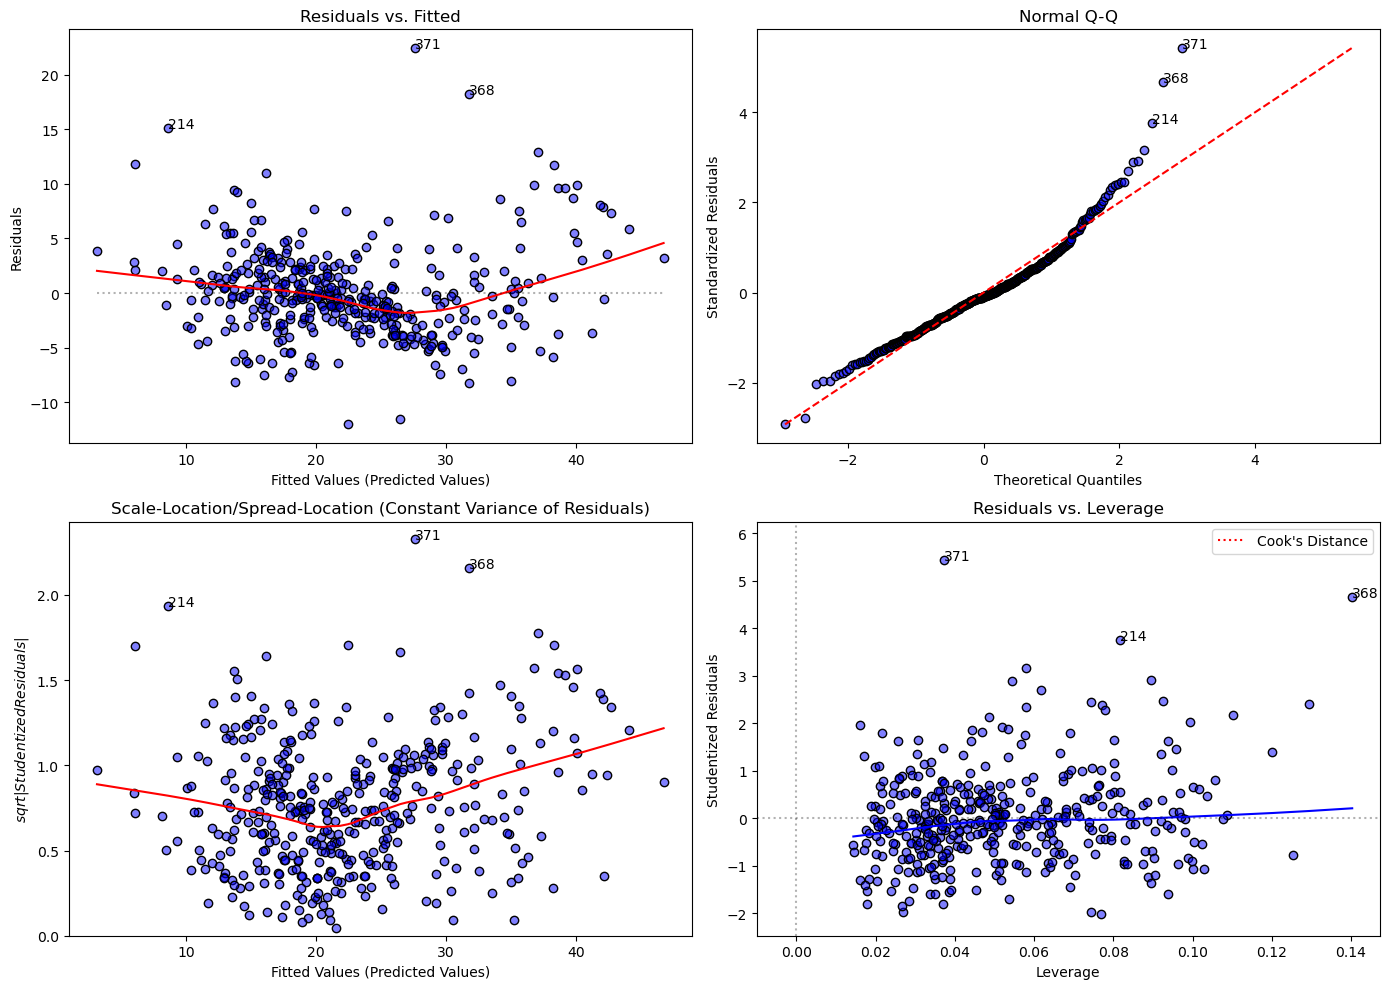

In [26]:
residual_plots(model_transformed_full)

In [27]:
scores = get_metrics(y_train_transformed, model_transformed_full.predict(X_train_transformed), y_test_transformed, model_transformed_full.predict(X_test_transformed), "Transformed Full Model", scores)
scores

Model  MAE_Train  MSE_Train  RMSE_Train  MAPE_Train  \
0              Full Model   3.190212  20.604025    4.539166   15.962938   
1  Transformed Full Model   2.974367  16.830971    4.102557   15.122694   

   RAE_Train  RSE_Train  MAE_Test    MSE_Test  RMSE_Test  MAPE_Test  RAE_Test  \
0   0.468509   0.237173  3.307085   24.818443   4.981811  17.439503  0.557222   
1   0.478322   0.217968  9.959316  156.572464  12.512892  23.465533  0.087856   

   RSE_Test        R2  
0  0.338431  0.762827  
1  0.048559  0.782032

# Calculate VIF scores (multicollinearity)

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X_transformed.columns
vif_data["VIF"] = [variance_inflation_factor(X_transformed.values, i) for i in range(X.shape[1])] # The index should start from 0 for the first column

print("VIF Scores before removing high VIF features:")
print(vif_data.sort_values(by="VIF", ascending=False))

VIF Scores before removing high VIF features:
    feature        VIF
0      crim  10.335714
4       nox   7.939393
7       dis   5.498959
19   rad_24   5.467405
8       tax   4.591764
2     indus   4.225048
6       age   3.842697
11    lstat   3.332578
1        zn   2.416851
9   ptratio   2.264917
5        rm   2.043632
15    rad_5   1.677850
13    rad_3   1.629966
12    rad_2   1.465462
10        b   1.455549
14    rad_4   1.367433
16    rad_6   1.259898
18    rad_8   1.165749
17    rad_7   1.156260
3      chas   1.108485


In [48]:
vif_columns = [c[0] for c in vif_data.values if c[1] > 5]
vif_columns

['crim', 'nox', 'dis', 'rad_24']

In [49]:
X_transformed_VIF = X_transformed.drop(vif_columns, axis=1)

X_transformed_VIF_const = sm.add_constant(X_transformed_VIF)

# split the data into train and test sets
X_train_transformed_VIF, X_test_transformed_VIF, y_train_transformed_VIF, y_test_transformed_VIF = train_test_split(X_transformed_VIF_const, y, test_size=0.2, random_state=123)

X_train_transformed_VIF.info()
print("\n")
y_train_transformed_VIF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404 entries, 203 to 365
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   const    404 non-null    float64
 1   zn       404 non-null    float64
 2   indus    404 non-null    float64
 3   chas     404 non-null    float64
 4   rm       404 non-null    float64
 5   age      404 non-null    float64
 6   tax      404 non-null    float64
 7   ptratio  404 non-null    float64
 8   b        404 non-null    float64
 9   lstat    404 non-null    float64
 10  rad_2    404 non-null    int64  
 11  rad_3    404 non-null    int64  
 12  rad_4    404 non-null    int64  
 13  rad_5    404 non-null    int64  
 14  rad_6    404 non-null    int64  
 15  rad_7    404 non-null    int64  
 16  rad_8    404 non-null    int64  
dtypes: float64(10), int64(7)
memory usage: 56.8 KB


<class 'pandas.core.series.Series'>
Index: 404 entries, 203 to 365
Series name: PRICE
Non-Null Count  Dtype  
------------

In [50]:
# build the multiple linear regression transformed full model
model_transformed_VIF = sm.OLS(y_train_transformed_VIF, X_train_transformed_VIF).fit()
print("Model Transformed VIF:\n")
print(model_transformed_VIF.summary())

Model Transformed VIF:

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     77.08
Date:                Sun, 22 Sep 2024   Prob (F-statistic):          1.61e-109
Time:                        15:04:47   Log-Likelihood:                -1180.7
No. Observations:                 404   AIC:                             2395.
Df Residuals:                     387   BIC:                             2464.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.3890      0

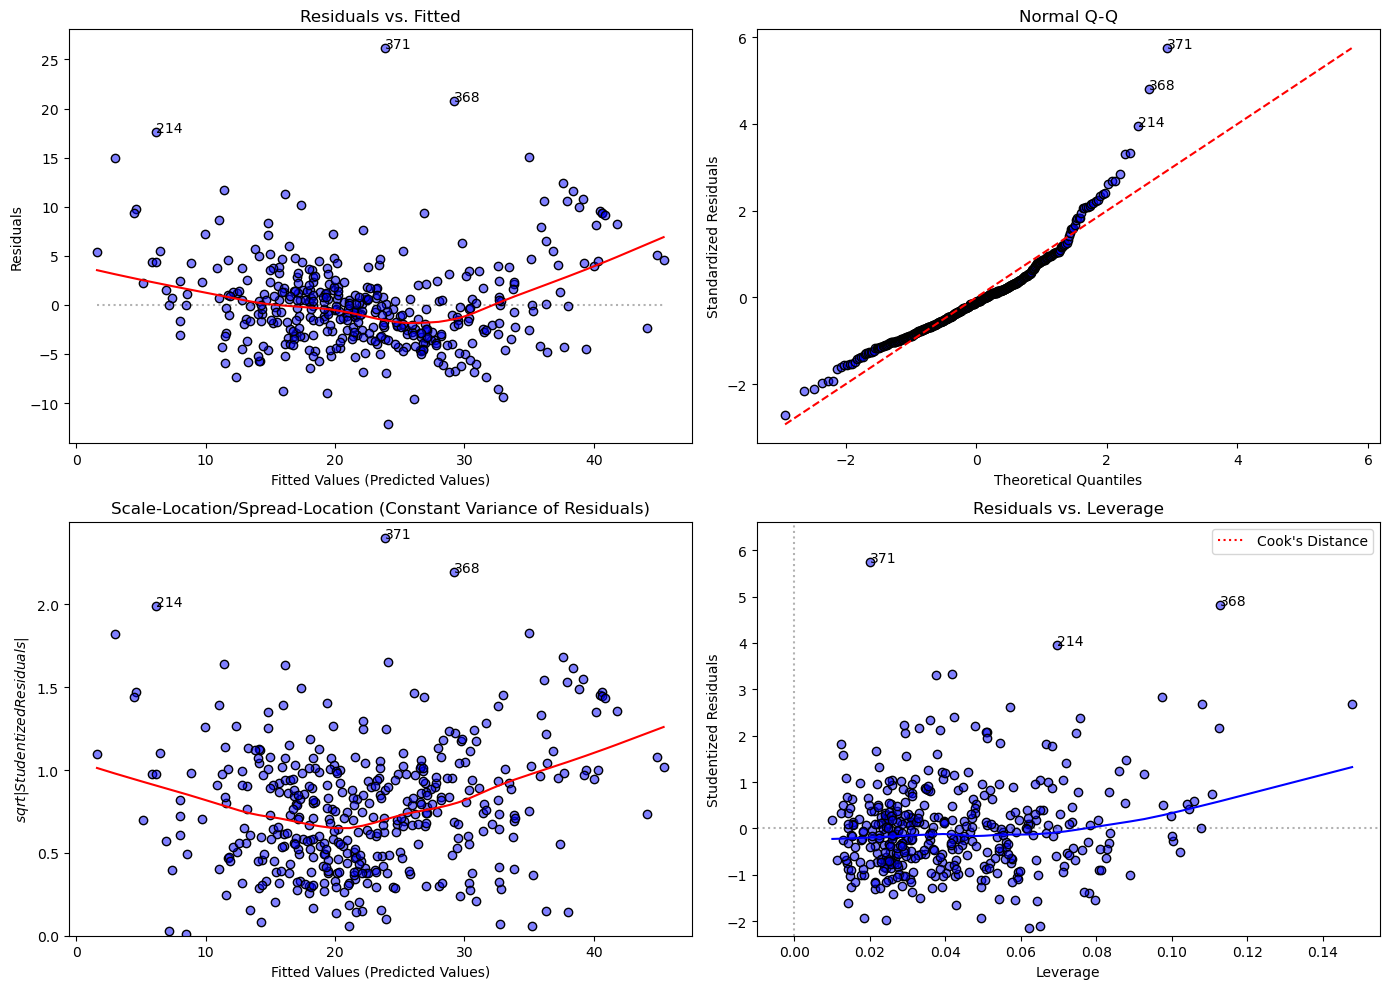

In [51]:
residual_plots(model_transformed_VIF)

In [53]:
scores = get_metrics(y_train_transformed_VIF, model_transformed_VIF.predict(X_train_transformed_VIF), y_test_transformed_VIF, model_transformed_VIF.predict(X_test_transformed_VIF), "Transformed VIF Model", scores)
scores

Model  MAE_Train  MSE_Train  RMSE_Train  MAPE_Train  \
0              Full Model   3.190212  20.604025    4.539166   15.962938   
1  Transformed Full Model   2.974367  16.830971    4.102557   15.122694   
2   Transformed VIF Model   3.243839  20.235001    4.498333   16.597178   

   RAE_Train  RSE_Train  MAE_Test    MSE_Test  RMSE_Test  MAPE_Test  RAE_Test  \
0   0.468509   0.237173  3.307085   24.818443   4.981811  17.439503  0.557222   
1   0.478322   0.217968  9.959316  156.572464  12.512892  23.465533  0.087856   
2   0.492704   0.238844  4.039082   30.655138   5.536708  19.147920  0.583375   

   RSE_Test        R2  
0  0.338431  0.762827  
1  0.048559  0.782032  
2  0.370519  0.761156